# Ziad Al-Ziadi

## Facial Emotion Recognition with SVM and ORB (Oriented FAST and Rotated BRIEF)

In the preceding section, we will implement several variations of a Facial Emotion Recognition (FER) solution. It will include a Support Vector Machine (SVM). The SVM will be used with ORB and will make use of the Real-world Affective Faces (RAF) dataset consisting of facial images that depcit emotions that are labeled as:

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

Ultimately, the objective is to have the SVM accurately predict the emotions in unseen images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.svm import SVC
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [ ]:
zip_path = "/content/drive/MyDrive/Comp_vis_CW/CW_Dataset.zip"
!cp "{zip_path}" .
!yes|unzip -q CW_Dataset.zip

In [ ]:
# Creating the test and trian path

train_image_path = "/content/train"
test_image_path = "/content/test"

train_txt = "/content/labels/list_label_train.txt"
test_txt = "/content/labels/list_label_test.txt"

# Creating a dataframe from our label txt files

colnames = ["Image_id", "Label"]
train_lab = pd.read_csv(train_txt, names = colnames, header = None, delim_whitespace = True)
test_lab = pd.read_csv(test_txt, names = colnames, header = None, delim_whitespace = True)

In [ ]:
# Here, I'm cleaning the label string to isolate the label value

train_lab["Image_id"] = train_lab["Image_id"].apply(lambda i: i[:-4])
test_lab["Image_id"] = test_lab["Image_id"].apply(lambda i: i[:-4])

# I append the string "_aligned.jpg" so that it matches our image names

train_lab["Image_id"] = train_lab["Image_id"] + "_aligned.jpg"
test_lab["Image_id"] = test_lab["Image_id"] + "_aligned.jpg"

# Here, I carry out a little bit of renidexing: note I have to +1 after to maintain correct label value

train_lab["Label"] = train_lab["Label"].apply(lambda i: i - 1)
train_lab["Label"] = train_lab["Label"].apply(lambda i: i + 1)

test_lab["Label"] = test_lab["Label"].apply(lambda i: i - 1)
test_lab["Label"] = test_lab["Label"].apply(lambda i: i + 1)

In [ ]:
# This function takes a dataframe and applies the ORB descriptor

def orb_des(data_frame):

  orb_img = []
  labels = []

  for i, row in data_frame.iterrows():
    img_path = "/content/train/"
    img_name = row[0]
    lbl = row[1]

    img_path += str(img_name)
    img = cv2.imread(img_path)
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
    # kp, des = orb.compute(img, kp)
    if des is not None:
      orb_img.append(des)
      labels.append(lbl)
  orb_array = np.vstack(orb_img)

  return orb_array, labels

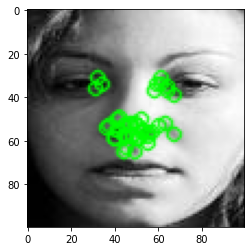

(<matplotlib.image.AxesImage at 0x7f11113a32d0>, None)

In [ ]:
for i, row in train_lab.iterrows():
  img_path = "/content/train/"
  img_name = row[0]

  img_path += str(img_name)
  img = cv2.imread(img_path)
  orb = cv2.ORB_create()
  kp, des = orb.detectAndCompute(img, None)

img2 = cv2.drawKeypoints(img,kp,img, flags=0, color=(0,255,0))
plt.imshow(img2),plt.show()

In [ ]:
# Applying ORB to our training set dataframe

orb_train, orb_train_lab = orb_des(train_lab)

# As per Lab 07, here we intialise the clustering of the descriptors to implement a BoVW approach

cluster = len(np.unique(orb_train_lab)) * 10
batch_size = orb_train.shape[0] // 4
k_means = MiniBatchKMeans(n_clusters = cluster, batch_size=batch_size).fit(orb_train)

In [ ]:
# Here, we slightly re-format the ORB image array in similar fashion to our inital ORB function

orb_img = []

for i, row in train_lab.iterrows():
  img_path = "/content/train/"
  img_name = row[0]
  img_path += str(img_name)
  img = cv2.imread(img_path)
  orb = cv2.ORB_create()
  kp, des = orb.detectAndCompute(img, None)
  if des is not None:
    orb_img.append(des)

img_list = []

# Here, we obtain the histograms for each image
for x in orb_img:
    hist = np.zeros(cluster)

    idx = k_means.predict(x)
    for y in idx:
        hist[y] = hist[y] + (1 / len(x))
    img_list.append(hist)
orb_hist = np.vstack(img_list)

In [ ]:
# Now we can split our training data into X_train and y_train

X_train, _, y_train, _ = train_test_split(orb_hist, orb_train_lab, test_size = 0.1, shuffle=True)

In [ ]:
#Initialising our first SVM 

clf = svm.SVC(kernel = "rbf")
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Once our SVM has been trained on our training set, we can evaluate on our test

# Reading in test data

test_img = []
test_labels = []

for i, row in test_lab.iterrows():
  img_path = "/content/test/"
  img_name = row[0]
  lbl = row[1]
  img_path += str(img_name)
  img = cv2.imread(img_path)
  test_img.append(img)
  test_labels.append(lbl)

_, X_test, _, y_test = train_test_split(test_img, test_labels, test_size = .99, shuffle=True)

In [ ]:
hist_list = []

for x in range(len(X_test)):
    test_img = img_as_ubyte(color.rgb2gray(X_test[x]))
    kp, descrip = orb.detectAndCompute(test_img, None)

    #  Reapplying the same histogram logic from above
    if descrip is not None:
        img_hist = np.zeros(cluster)
        idx = k_means.predict(descrip)
        for y in idx:
            img_hist[y] = img_hist[y] + (1 / len(descrip))
        hist_list.append(img_hist)
    else:
        hist_list.append(None)

# Removing images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
#Prediciting on test data

clf_pred = clf.predict(hist_array).tolist()

In [ ]:
print(f"""Classification report for classifier {clf}:
      {metrics.classification_report(y_test, clf_pred)}\n""")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
                    precision    recall  f1-score   support

           1       0.17      0.00      0.01       322
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       158
           4       0.39      0.97      0.56      1136
           5       0.44      0.05      0.09       466
           6       0.00      0.00      0.00       157
           7       0.36      0.05      0.09       648

    accuracy                           0.39      2961
   macro avg       0.19      0.15      0.10      2961
weighted avg       0.32      0.39      0.25      2961




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that our SVM used with ORB has performed relatively poorly with an accuracy of 39% as well as dismal F1 scores. The accuracy is 2% lower than that of the SIFT implementation. One considerable difference was the speed difference in both training and testing - our ORB implementation performed faster than our ORB implementation.

Again, we did implement a relatively simply SVM. We will now conduct a grid search on our SVM to see whether we can derive better parameters to use with our ORB descriptor.

In [ ]:
# Defining the SVM parameters we would like to tune using grid search

svm_params = [
    {"kernel": ["linear", "poly", "rbf"],
    "C" : [1, 10]}]

In [ ]:
# The scores our SVM will use

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), svm_params, scoring='%s_macro' % score,  cv =2, n_jobs =-1
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Classification report for Train set:")
    print()
    y_true_train, y_pred_train = y_train, clf.predict(X_train)
    print(classification_report(y_true_train, y_pred_train))
    print()

    print("Classification report for Test set:")
    print()
    y_test_, y_pred_test = y_test, clf.predict(hist_array)
    print(classification_report(y_test_, y_pred_test))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on training set:

{'C': 10, 'kernel': 'rbf'}

Grid scores on training set:

0.143 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
0.142 (+/-0.004) for {'C': 1, 'kernel': 'poly'}
0.148 (+/-0.003) for {'C': 1, 'kernel': 'rbf'}
0.143 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
0.157 (+/-0.009) for {'C': 10, 'kernel': 'poly'}
0.190 (+/-0.010) for {'C': 10, 'kernel': 'rbf'}

Classification report for Train set:

              precision    recall  f1-score   support

           1       0.93      0.83      0.88      1136
           2       0.97      0.73      0.84       249
           3       1.00      0.74      0.85       626
           4       0.86      0.98      0.91      4213
           5       0.90      0.87      0.88      1770
           6       0.90      0.77      0.83       639
           7       0.92      0.88      0.90      2185

    accuracy                           0.89     10818
   macro avg       0.93      0.83      0

#### We can see that even with hyperparameters used with a grid search. the SVM stil performs poorly across virtually all metrics. For facial recognition problems, the SVM even with ORB applied is most probably not best model.

In [ ]:
import pickle

with open("orb_svm.pkl", "wb") as orb_svm:
    pickle.dump(clf, orb_svm)